Run the below cell to import all relevant notebooks.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [2]:
pip install -U gif

Requirement already up-to-date: gif in /home/avani/anaconda3/lib/python3.8/site-packages (3.0.0)
Note: you may need to restart the kernel to use updated packages.


# Logistic Regression

Logistic Regression is a discriminative learning algorithm where the posterior probabilities of $K$ classes can be learnt directly from the data. We would like to ensure that the probabilities sum to one and remain in $[0,1]$.

An initial intuition would be to use our standard linear regression algorithm to predict the $K$ classes given our input data. However, one can find specific examples where this method won't make sense since our prediction from regression model can have values greater than 1 and less than 0.

Instead, we can use the logistic/sigmoid activation function and define our hypothesis as follows:

\begin{equation}
\mathbf{h_w(x) = \sigma(w^{\top}x) = \sigma(z) = \frac{1}{1+e^{-z}}}
\end{equation}

Given this logistic regression model, we can choose values for weights $\mathbf{w}$ by deriving it as the maximum likelihood estimator.

Let's assume the following:

\begin{align}
\mathbf{p(y = 1 \; | \; x;w)} &= \mathbf{h_w(x)}\\
\mathbf{p(y = 0 \; | \; x;w)} &= \mathbf{1 - h_w(x)}
\end{align}

A more precise form would be:

\begin{equation}
\mathbf{P(Y \; | \; X;w)} = \mathbf{(h_w({x}))^y \; (1 - h_w({x}))^{1-y}}
\end{equation}

<br>

Assuming that our $\mathbf{m}$ training examples are independently generated, our MLE estimate is as follows:

\begin{align}
L(\mathbf{w}) &= \mathbf{P(Y \; | \; X;w)}\\
&=\prod_{i=1}^{\mathbf{m}} \; \mathbf{P(y^{(i)} \; | \; x^{(i)};w)}
\end{align}

As before, we would like to maximize the log likelihood or minimize the negative log likelihood.

\begin{align}
l(\mathbf{w}) &= \operatorname*{argmax}_\mathbf{w} \; \log L(\mathbf{w}) = \operatorname*{argmin}_\mathbf{w} \; - \log L(\mathbf{w})\\
&= \operatorname*{argmax}_\mathbf{w} \; \sum_{i=1}^\mathbf{m} \; \mathbf{y^{(i)}} \log \mathbf{h(x^{(i)}) \; + \; (1-y^{(i)})} \log \mathbf{(1-h(x^{(i)}))}\\
&= \operatorname*{argmin}_\mathbf{w} \; - \sum_{i=1}^\mathbf{m} \; \mathbf{y^{(i)}} \log \mathbf{h(x^{(i)}) \; + \; (1-y^{(i)})} \log \mathbf{(1-h(x^{(i)}))}
\end{align}

<br>

The above equation is nothing but the loss function for logistic regression. Note that there is no closed-form solution to minimize this likelihood or loss function. Hence, we would resolve to our gradient descent for making parameter update. The gradient to minimize the above equation is:

\begin{equation}
\nabla_{\mathbf{w}_j} = \mathbf{(y - h_w(x)) \; x}_j
\end{equation}

Therefore, our gradient update rule is:

\begin{equation}
\mathbf{w}_j \leftarrow \mathbf{w}_j + \alpha \; \nabla_{\mathbf{w}_j}
\end{equation}

The gradient update can be made on a single sample, mini-batch SGD, or batch gradient descent. In both the examples, we will look only at batch gradient descent.

In [4]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'utils'

In [2]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

## Example 1 - Binary classifier on a toy dataset

We will now implement logistic regression on a toy dataset that consists of data points in 2D from two different classes.

In [3]:
fig = plt.figure(figsize=(8,8));

np.random.seed(16)

# Generating a dataset
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
y = y.reshape((-1, 1))

# Absorbing weight b of the hyperplane
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

NameError: name 'plt' is not defined

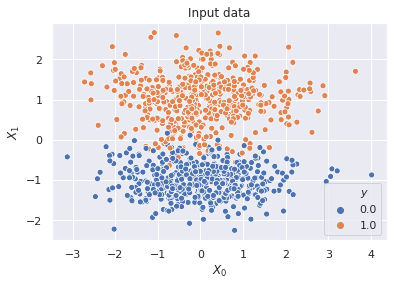

In [6]:
plot_2D_input_datapoints(X, y)

In [7]:
# Train-Val-Test split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (700, 3)
Validation dataset:  (100, 3)
Test dataset:  (200, 3)


In [8]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :2])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

Before diving into the training methodology, let us look at the pseudo code for logistic regression training.


1.   Initialize the weights $w$ from a uniform distribution.
2.   Normalize the input $X$
3.   Compute the weighted inputs $z$ and pass it through sigmoid activation, $sigmoid(z)$.
4.   Calculate the gradient based on the cross entropy loss function.
5.   Update the weights.
6.   Repeat steps 1-5 until convergence.




In [1]:
# Train on the dataset
def train(X_train, Y_train, weights, num_epochs=1000, learning_rate=0.1):

    """ Method to train a logistic regression model.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(y)

    history_weights = []
    epoch = 1

    # Training using Batch GD
    while epoch <= num_epochs:

        # Appending previous history weights/first initialized weights
        history_weights.append(weights)

        # Computing weighted inputs and predicting output
        w_transpose_x = np.dot(X_train, weights)
        y_pred = sigmoid(w_transpose_x)

        # Calculating gradient and updating weights
        gradient = 1 * np.dot(X_train.T, (Y_train - y_pred))
        weights += (learning_rate/n_samples) * gradient
        weights = np.round(weights, decimals=7)
        epoch += 1

    print("Training complete")

    return history_weights

In [10]:
# Initializing weights from uniform distribution
weights = weight_init_uniform_dist(X_normalized_train, Y_train)

In [11]:
trained_weights = train(X_normalized_train, Y_train, weights, num_epochs=50, learning_rate=0.1)

Training complete


In [12]:
best_weights = trained_weights[-1]

print("Evaluation results")
train_acc, _ = get_prediction(X_train, Y_train, best_weights, get_acc=True, model_type='logreg', predict='yes')
val_acc, _ = get_prediction(X_val, Y_val, best_weights, get_acc=True, model_type='logreg', predict='yes')
test_acc, _ = get_prediction(X_test, Y_test, best_weights, get_acc=True, model_type='logreg', predict='yes')

print("Training accuracy: {:.3f}" .format(train_acc))
print("Validation accuracy: {:.3f}" .format(val_acc))
print("Test accuracy: {:.3f}" .format(test_acc))

Evaluation results
Training accuracy: 96.857
Validation accuracy: 95.000
Test accuracy: 95.500


In [13]:
generate_gifs(X_train, Y_train, trained_weights, 'train', path='content/logistic_reg_training_decision_boundary.gif', model_type='logreg', predict='yes')

Gif/image generated


![Logistic regression decision boundary](https://drive.google.com/uc?id=1Q95Vwn94ZEkrZykEHwjfc3D3zVBzoszm)

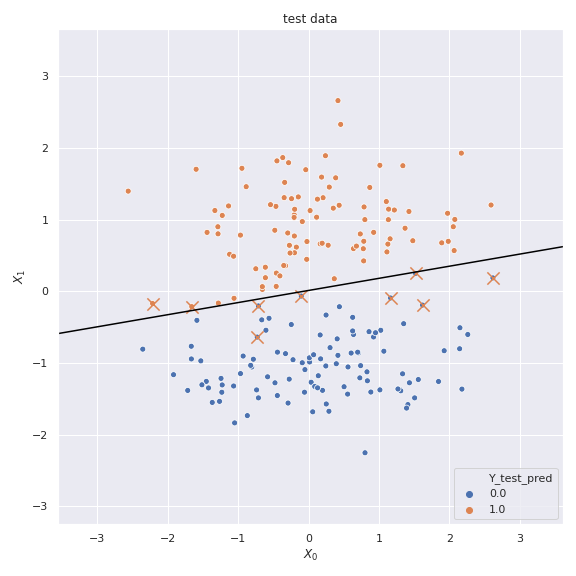

In [14]:
plot_decision_boundary(X_test, Y_test, best_weights, dataset_type='test', model_type='logreg', predict='yes')

## Example 2 - From binary classification to multiclass classification - One vs All classifier

In the previous section, we saw how to build a binary classifier using logistic regression. Next, we will make a multiclass classifier using the binary classifier we built above by using them in one-vs-all and one-vs-one way. In this section we will see how to build a one-vs-all classifier. If we have $K$ classes to classify, we will $K$ binary classifiers. Say, for instance, we have 3 classes: $A, B, $ and $C$. In one-vs-all, we will train a binary classifier where true labels $(+1)$ will correspond to class $A$ and false labels $(0)$ will correspond to be class $B$ and $C$.

In [15]:
fig = plt.figure(figsize=(8,8));

np.random.seed(4)

# Getting only linearly separable dataset
separable = False
while not separable:
    samples = make_classification(n_samples=450, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    green = samples[0][samples[1] == 2]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() 
                  or green[:, k].min() > blue[:, k].max() or green[:, k].min() > red[:, k].max() 
                  or blue[:, k].min() > green[:, k].max() or red[:, k].min() > green[:, k].max() for k in range(2)])

X, y = samples

y = y.reshape((-1, 1))

# Absorbing weight b of the hyperplane
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 576x576 with 0 Axes>

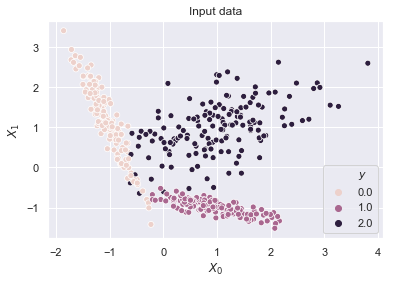

In [16]:
plot_2D_input_datapoints(X[:, :2], y)

In [17]:
# Train-Val-Test split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (315, 3)
Validation dataset:  (45, 3)
Test dataset:  (90, 3)


In [18]:
def train_one_vs_all(X_train, Y_train, base_weights, num_epochs=1000, learning_rate=0.1):

    """Method to train a multiclass classifier using one vs all technique.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    base_weights: ndarray (num_features vs n_outputs)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(y)

    history_weights = []
    weights_k_classes = []
    epoch = 1

    classes = np.unique(Y_train)

    # Training using Batch GD
    for k in classes:
        # one-vs-all binary classifier
        binary_y_train = np.where(Y_train == k, 1, 0)

        weights = base_weights
        # Appending previous history weights/first initialized weights
        #weights_k_classes.append(weights)

        for epoch in range(1, num_epochs+1):
    
            # Computing weighted inputs and predicting output
            w_transpose_x = np.dot(X_train, weights)
            y_pred = sigmoid(w_transpose_x)

            # Calculating gradient and updating weights
            gradient = 1 * np.dot(X_train.T, (binary_y_train - y_pred))
            weights += (learning_rate/n_samples) * gradient
            weights = np.round(weights, decimals=7)

            #weights_k_classes.append(weights)
            epoch += 1
 
        #history_weights.append(weights_k_classes)
        history_weights.append(weights)
        #weights_k_classes = []

    print("Training complete")
    return history_weights

In [19]:
# Initializing weights from uniform distribution
weights = weight_init_uniform_dist(X_train, Y_train)

In [20]:
trained_weights = train_one_vs_all(X_train, Y_train, weights, num_epochs=50, learning_rate=0.1)

Training complete


In [21]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(trained_weights, X_input, Y_input):
  
    num_classes = len(np.unique(Y_input))
    scores = np.zeros((num_classes, (X_input.shape)[0]))

    for k in range(num_classes):
    
        binary_y_input = np.where(Y_input == k, 1, 0)

        w_transpose_x = np.dot(X_input, trained_weights[k])
        y_pred = sigmoid(w_transpose_x)
        y_pred = y_pred.reshape((-1,))
        scores[k, :] = y_pred

    pred_X = np.argmax(scores, axis=0)
    return pred_X

In [22]:
pred_train_one_vs_all = predict_one_vs_all(trained_weights, X_train, Y_train)
pred_val_one_vs_all = predict_one_vs_all(trained_weights, X_val, Y_val)
pred_test_one_vs_all = predict_one_vs_all(trained_weights, X_test, Y_test)

pred_train_one_vs_all = pred_train_one_vs_all.reshape((-1, 1))
pred_val_one_vs_all = pred_val_one_vs_all.reshape((-1, 1))
pred_test_one_vs_all = pred_test_one_vs_all.reshape((-1, 1))

print('Training dataset accuracy: %f' % (np.mean(Y_train == pred_train_one_vs_all)))
print('Validation dataset accuracy: %f' % (np.mean(Y_val == pred_val_one_vs_all)))
print('Test datast accuracy: %f' % (np.mean(Y_test == pred_test_one_vs_all)))

Training dataset accuracy: 0.926984
Validation dataset accuracy: 0.844444
Test datast accuracy: 0.977778


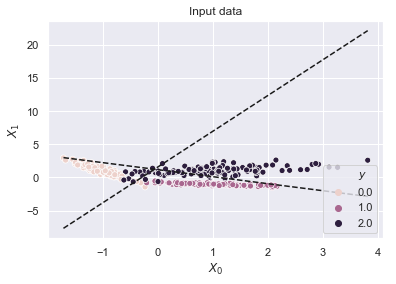

In [23]:
plot_2D_input_datapoints(X_train[:, :2], Y_train)
plt.xlabel("$X_0$"); plt.ylabel("$X_1$")

for weight in [trained_weights[0], trained_weights[2]]:
    j = np.array([X_train[:, 0].min(), X_train[:, 0].max()])
    k = -(j * weight[0] + weight[2]) / weight[1]
    plt.plot(j, k, color='k', linestyle="--")

## (Optional Reading) Multiclass Logistic Regression

The multi-class scenario for logistic regression is quite similar to the binary case, except that the label $y$ is now an integer in {1, ...., K} where $K$ is the number of classes. Instead of using sigmoid activation function, we know use softmax activation which calculates scores for all classes, instead of just one class in the case sigmoid activation. The softmax function takes weighted inputs and normalizes them into a probability distribution, thereby forcing the prediction score to be between in the interval $[0, 1]$. The class scores for each examples will add up to 1. The class score with the highest probability will be the predicted class. The softmax function is defined as follows:

\begin{align}
\mathbf{\sigma(z_i)} &= \mathbf{\frac{e^{z_{(i)}}}{\sum_{j=1}^K e^{z_{(j)}}}} \ \ \ \text{for}\ i=1,.,.,.,K\
\end{align}

where, $\mathbf{z_i}$ are the weighted inputs for each class. 

For instance, for a given vector:

$ z = [0.6, 1.1, -1.5, 1.2, 3.2, -1.1]$

the resultant softmax $(z)$ is:

$ softmax(z) = [0.055, 0.09, 0.0067, 0.1, 0.74, 0.01]$

The loss function for multiclass logistic regression slightly changes since we now have K output classes.

\begin{align}
loss &= L(y, \hat y)\\
&=  - \sum_i y_i \log \hat y_i\\
&= - \log \hat y_c
\end{align}

We can learn the weights by performing gradient descent on the loss function w.r.t to a certain number of hyperparameters. As in the case of binary logistic regression, the loss function is convex and hence, gradient will converge to a global minimum.

We can also apply $L_2$ regularization to the loss function. 

You can try to implement this variant for the multiclass synthetic dataset above.